# VAR India

Vector auto-regressive models

1. [Imports](#imports)
2. [Ingestion](#ingestion)
3. [Plotting](#plotting)
4. [Statistical tests](#stattests1)
5. [Differencing](#diff)


### First-Order Differencing
1. [Train test split - first order differencing](#traintest1)
2. [Find order p of VAR](#var_p_1)
3. [VAR(13) Model](#var13_1)
4. [Plots of first differenced predictions](#diff1_plot)
5. [Undifferencing and predicting](#undiff_1)
6. [MAPE](#mape1)

### VARMA
1. [VARMA](#varma)

<a name=imports></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a name=ingestion></a>
## Ingestion

In [2]:
daily_cases_india = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv', parse_dates=['Date'], index_col=0)
daily_vacc_india = pd.read_csv('../../cleaned_datasets/india/daily_vacc_india.csv', parse_dates=['Updated On'])

In [3]:
daily_cases_india.dtypes

Date         datetime64[ns]
Confirmed           float64
Deaths              float64
Recovered           float64
Active              float64
dtype: object

In [4]:
daily_cases_india

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-30,1.0,0.0,0.0,0.0
1,2020-01-31,0.0,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...,...
617,2021-10-08,19740.0,248.0,0.0,0.0
618,2021-10-09,18166.0,214.0,0.0,0.0
619,2021-10-10,18132.0,193.0,0.0,0.0
620,2021-10-11,14313.0,181.0,0.0,0.0


In [5]:
daily_vacc_india.dtypes

Updated On     datetime64[ns]
Total_Doses           float64
First_Dose            float64
Second_Dose           float64
dtype: object

In [6]:
daily_vacc_india

,Updated On,Total_Doses,First_Dose,Second_Dose
0,2021-01-16,NaN,NaN,NaN
1,2021-01-17,20656.0,20656.0,0.0
2,2021-01-18,81690.0,81690.0,0.0
3,2021-01-19,192152.0,192152.0,0.0
4,2021-01-20,111510.0,111510.0,0.0
...,...,...,...,...
265,2021-10-08,16299888.0,8574512.0,7725376.0
266,2021-10-09,14222216.0,7383094.0,6839122.0
267,2021-10-10,9980692.0,5006976.0,4973716.0
268,2021-10-11,13936784.0,7123464.0,6813320.0


In [7]:
cases_vacc = daily_cases_india.merge(daily_vacc_india, how='outer', left_on='Date', right_on='Updated On')
cases_vacc = cases_vacc[["Date", "Confirmed", "Total_Doses"]]
cases_vacc

,Date,Confirmed,Total_Doses
0,2020-01-30,1.0,NaN
1,2020-01-31,0.0,NaN
2,2020-02-01,0.0,NaN
3,2020-02-02,1.0,NaN
4,2020-02-03,1.0,NaN
...,...,...,...
617,2021-10-08,19740.0,16299888.0
618,2021-10-09,18166.0,14222216.0
619,2021-10-10,18132.0,9980692.0
620,2021-10-11,14313.0,13936784.0


In [8]:
cases_vacc.fillna(0, inplace=True)
indexed = cases_vacc.set_index('Date')
indexed

,Confirmed,Total_Doses
Date,,
2020-01-30,1.0,0.0
2020-01-31,0.0,0.0
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,1.0,0.0
...,...,...
2021-10-08,19740.0,16299888.0
2021-10-09,18166.0,14222216.0
2021-10-10,18132.0,9980692.0


<a name=plotting></a>
## Plot initial data

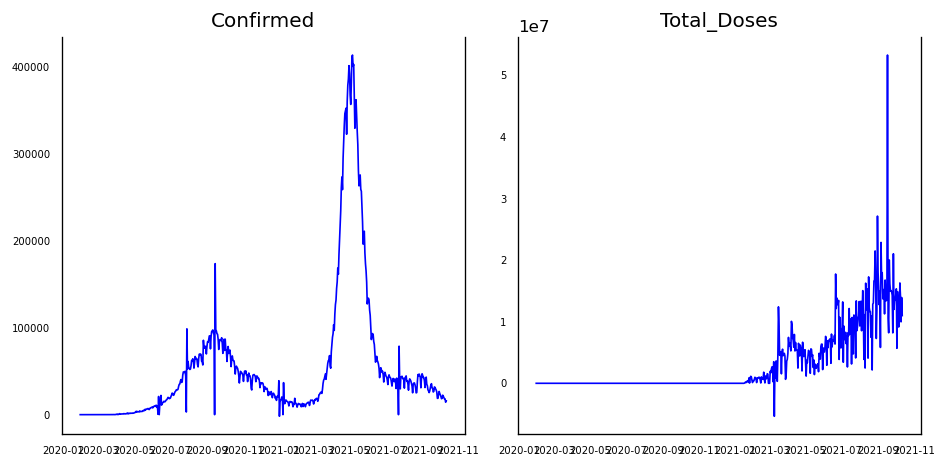

In [9]:
def plot_subplots(indexed):
    
    if type(indexed) == pd.DataFrame:
        nrows = int(len(indexed.columns)/2)
    else:
        nrows = 1
        
    fig, axes = plt.subplots(nrows=nrows, ncols=2, dpi=120, figsize=(8,4))
    for i, ax in enumerate(axes.flatten()):
        
        if type(indexed) == list:
            # fig, ax = plt.subplots()
            # fig.set_size_inches(8, 8)

            ax.plot(indexed[0][indexed[0].columns[i]], color='blue', label = 'Train')
            ax.plot(indexed[1][indexed[1].columns[i]], color='red', label = 'Test')
            ax.legend(loc = 'best')
            # Decorations
            ax.set_title(indexed[0].columns[i])
        else:    
            data = indexed[indexed.columns[i]]
            ax.plot(data, color='blue', linewidth=1)
            # Decorations
            ax.set_title(indexed.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout()
    
plot_subplots(indexed)

<a name=stattests1></a>
## Statistical tests

### Johansen co-integration test

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(indexed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  3.31      > 12.3212   =>   False
Total_Doses ::  0.69      > 4.1296    =>   False


### Augmented DF Test

In [11]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)


# ADF Test on each column
for name, column in indexed.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.842259
p-value                          0.002503
#lags used                      15.000000
number of observations used    606.000000
critical value (1%)             -3.441187
critical value (5%)             -2.866321
critical value (10%)            -2.569316
dtype: float64


Observations of Dickey-fuller test
Test Statistic                  -0.170254
p-value                          0.941976
#lags used                      13.000000
number of observations used    608.000000
critical value (1%)             -3.441151
critical value (5%)             -2.866305
critical value (10%)            -2.569308
dtype: float64




The TS is not stationary

<a name=diff></a>
## Differencing

## First order differencing

In [12]:
df_diff_1 = indexed.diff().dropna()
df_diff_1

,Confirmed,Total_Doses
Date,,
2020-01-31,-1.0,0.0
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,0.0,0.0
2020-02-04,-1.0,0.0
...,...,...
2021-10-08,-1517.0,5513592.0
2021-10-09,-1574.0,-2077672.0
2021-10-10,-34.0,-4241524.0


In [13]:
# ADF Test on each column
for name, column in df_diff_1.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -4.673828
p-value                          0.000094
#lags used                      19.000000
number of observations used    601.000000
critical value (1%)             -3.441278
critical value (5%)             -2.866361
critical value (10%)            -2.569338
dtype: float64


Observations of Dickey-fuller test
Test Statistic                -8.925407e+00
p-value                        1.014498e-14
#lags used                     1.900000e+01
number of observations used    6.010000e+02
critical value (1%)           -3.441278e+00
critical value (5%)           -2.866361e+00
critical value (10%)          -2.569338e+00
dtype: float64




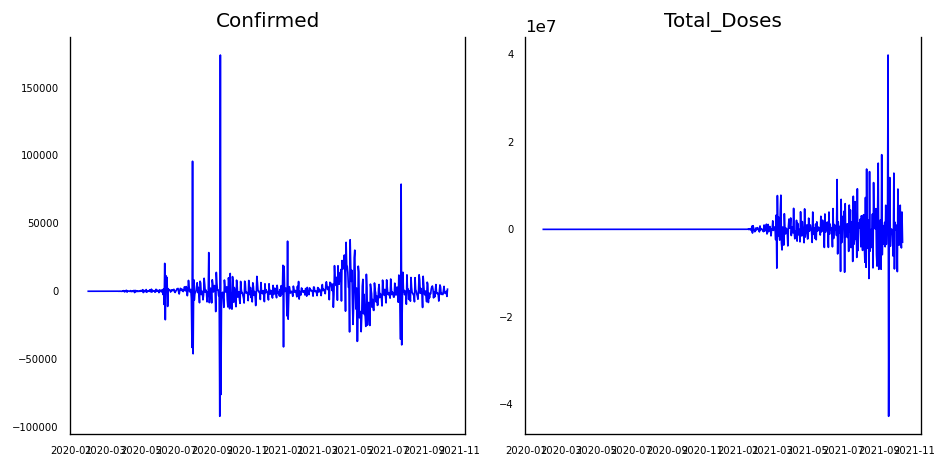

In [14]:
plot_subplots(df_diff_1)

<a name=traintest1></a>
## Train-test split

### Train-test split - first order differenced

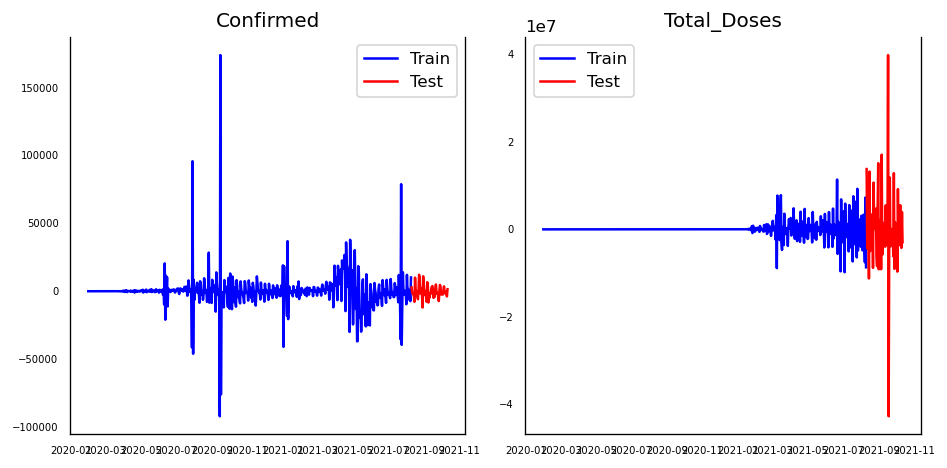

In [15]:
percent_90 = int(len(df_diff_1)*0.9)

train = df_diff_1.iloc[:percent_90].dropna()
test = df_diff_1.iloc[percent_90:]

plot_subplots([train, test])

<a name=var_p_1></a>
### Finding the best value of p for VAR(p)

Using AIC, BIC, FPE, HQIC

In [16]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)

x = model.select_order(maxlags=25)
x.summary()

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,47.95,47.96,6.644e+20,47.95
1,47.39,47.44,3.820e+20,47.41
2,47.30,47.38,3.496e+20,47.33
3,47.30,47.41,3.493e+20,47.35
4,47.27,47.41,3.371e+20,47.32
5,47.25,47.43,3.310e+20,47.32
6,47.11,47.32,2.896e+20,47.20
7,46.97,47.21,2.499e+20,47.06
8,46.82,47.09,2.156e+20,46.93
9,46.77,47.08,2.055e+20,46.89


At p = 13 the value of BIC and HQIC are at their local minima

<a name=var13_1></a>
### VAR(13) Model

In [17]:
model_fitted = model.fit(13)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Dec, 2021
Time:                     12:29:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    46.9967
Nobs:                     545.000    HQIC:                   46.7372
Log likelihood:          -14183.1    FPE:                1.68041e+20
AIC:                      46.5706    Det(Omega_mle):     1.52551e+20
--------------------------------------------------------------------
Results for equation Confirmed
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 -75.250415       430.223174           -0.175           0.861
L1.Confirmed           -0.755147         0.043015          -17.556           0.000
L1.Total_Doses          0.000375         0.00034

In [18]:
forecast_input = test.values


forecast_input
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(forecast_input))


df_forecast = pd.DataFrame(fc, index=test.index, columns=test.columns + '_forecast')

forecasted_conf = df_forecast.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc = df_forecast.join(test)[['Total_Doses', 'Total_Doses_forecast']]

<a name=diff1_plot></a>
### Plot Predictions on Diffed

In [19]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()

In [20]:
#plot_fore_test(forecasted_conf[['Confirmed']], forecasted_conf[['Confirmed_forecast']], title='Daily cases')

In [21]:
#plot_fore_test(forecasted_vacc[['Total_Doses']], forecasted_vacc[['Total_Doses_forecast']], title='Daily vaccinations')

<a name=undiff_1></a>

## Un-differencing and Plotting

In [22]:
def invert_transformation(diffed, original):
    """Revert back the differencing to get the forecast to original scale."""
    df_copy = original.copy()
    
    columns = diffed.columns
    
    for col in columns:
        # Add corresponding diff column
        df_copy[f'undiff_{col}'] = original[col]
        df_copy[f'undiff_{col}'][1:] = diffed[col]
        df_copy[f'undiff_{col}'] = df_copy[f'undiff_{col}'].cumsum()
    
        df_copy.drop(col, axis=1, inplace=True)
        
    return df_copy

In [23]:
# Check if un-diffed df_diff_1 is the same as original

#inverted = invert_transformation(df_diff_1, indexed)
#(inverted[['undiff_Confirmed']] - indexed[['Confirmed']]).isna().sum()

In [24]:
# Un-diff the test dataset

start_index = indexed.index.get_loc(test.index[0])-1
test_original = invert_transformation(test, indexed.iloc[start_index:])

#test_original

In [25]:
renamed_df = df_forecast.rename(columns={'Confirmed_forecast': 'Confirmed', 'Total_Doses_forecast': 'Total_Doses'}, inplace=False)


start_index = indexed.index.get_loc(renamed_df.index[0])-1
fore_original = invert_transformation(renamed_df, indexed.iloc[start_index:])

#fore_original

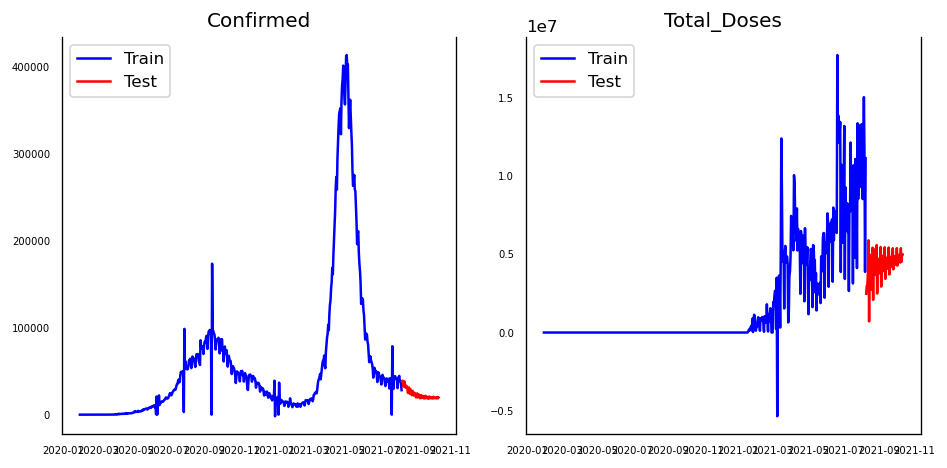

In [26]:
end_index = indexed.index.get_loc(fore_original.index[0])
train_original = indexed[:end_index]
plot_subplots([train_original, fore_original])

In [27]:
def plot_train_test_fore(train, test, fore, title='Forecast vs Actuals', ylabel='', xlabel='Date', figpath=None):
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fore, label='forecast')
    fig = plt.gcf()
    
    plt.xlabel=xlabel
    plt.ylabel=ylabel

    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
    if figpath is not None:
        fig.savefig(figpath, format='eps', bbox_inches='tight')

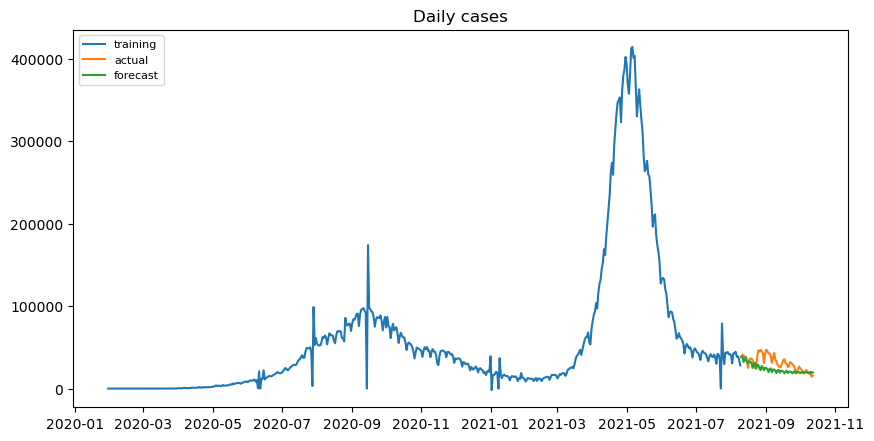

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [28]:
# Plot of daily cases
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/v_ar/india_cases.eps')


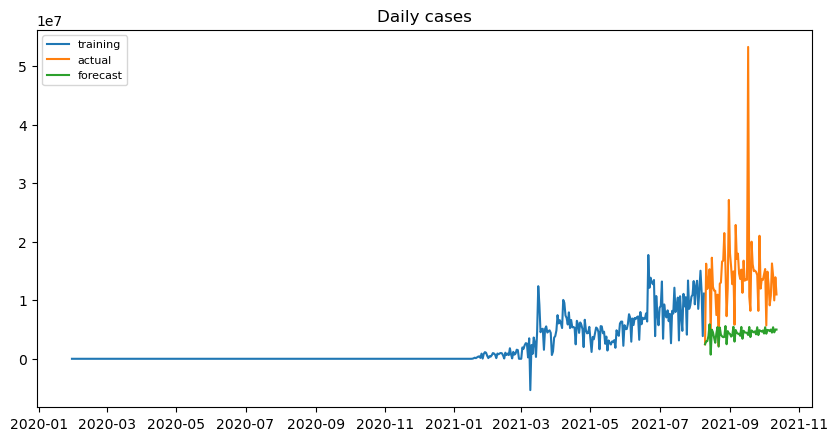

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
# Plot of daily cases
plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily cases', figpath='../../figures/v_ar/india_vacc.eps')


### Plot the forecasts

In [30]:
#plot_fore_test(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title='Daily cases')

In [31]:
#plot_fore_test(test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily vaccinations')

In [32]:
#plot_fore_test(test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily vaccinations')

<a name=mape1></a>
### MAPE

In [33]:
def MAPE(Y_actual,Y_Predicted, title):
    mask = Y_actual != 0
    
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100
    print(f"MAPE of {title} is {mape[mape.index[0]]}%")
    return mape[mape.index[0]]


mape_vacc = MAPE(test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title="Daily vaccinations")
mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title="Daily cases")

MAPE of Daily vaccinations is 64.48980378286639%
MAPE of Daily cases is 24.440611111244007%


Clearly, a VAR model is not good enough to make predictions

In [34]:
from sklearn.metrics import mean_absolute_error


mean_absolute_error(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']])

8424.078691094897

<a name=varma></a>

## VARMA

In [35]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

# evaluate an VARMA model for a given order (p,d,q)
def evaluate_varma_model(train, test, varma_order):
    
    model = VARMAX(train, order=varma_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(len(test))
    error = mean_squared_error(test, yhat)
    return error

In [36]:
# Grid search


# evaluate combinations of p and q values for an VARMA model
def evaluate_models(train, test, p_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for q in q_values:
            order = (p,q)
            try:
                mse = evaluate_varma_model(train, test, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('VARMA%s MSE=%.3f' % (order,mse))
            except:
                continue
    print()
    print('Best VARMA%s MSE=%.3f' % (best_cfg, best_score))

In [37]:
import warnings
warnings.filterwarnings("ignore")

p_values = range(1, 3)
q_values = range(1, 3)

evaluate_models(train, test, p_values, q_values)

VARMA(1, 1) MSE=45532149019906.836
VARMA(1, 2) MSE=45565457972346.445
VARMA(2, 1) MSE=45532382558558.805
VARMA(2, 2) MSE=45594790055084.695

Best VARMA(1, 1) MSE=45532149019906.836


In [38]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train, order=(1,1))
model_fit = model.fit()
yhat = model_fit.forecast(len(test))
#yhat

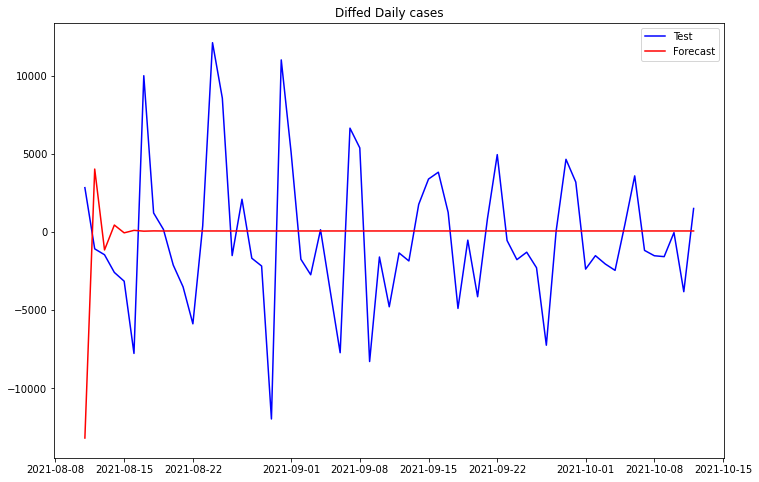

In [39]:
plot_fore_test(test[['Confirmed']], yhat[['Confirmed']], title='Diffed Daily cases')

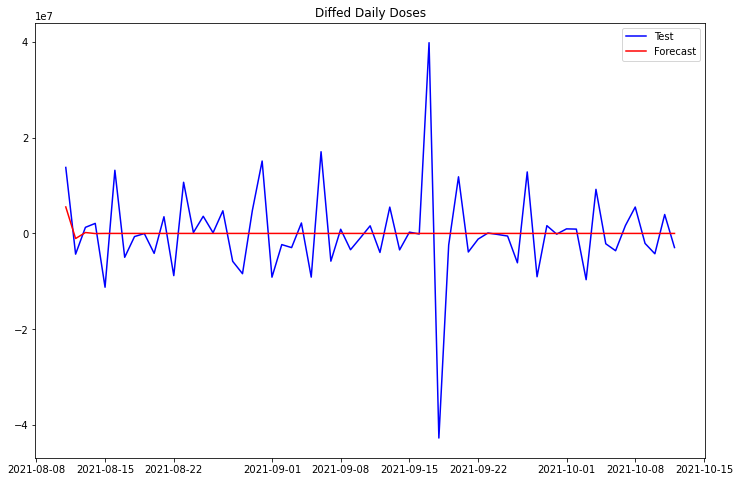

In [40]:
plot_fore_test(test[['Total_Doses']], yhat[['Total_Doses']], title='Diffed Daily Doses')

In [41]:

# Un-diff the test dataset

fore_original_3 = invert_transformation(yhat, indexed.iloc[start_index:])
fore_original_3

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-08-10,38353.000000,2.481870e+06
2021-08-11,25164.275224,8.012873e+06
2021-08-12,29198.575061,6.953864e+06
2021-08-13,28053.468507,7.145001e+06
2021-08-14,28503.041010,7.125721e+06
...,...,...
2021-10-08,32261.373361,7.439779e+06
2021-10-09,32331.363753,7.445465e+06
2021-10-10,32401.354146,7.451151e+06


In [42]:
#plot_fore_test(test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases')

In [43]:
#plot_fore_test(test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily Doses')

In [44]:
#plot_subplots([train_original, fore_original_3])

In [45]:
# Plot of daily cases
#plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')




In [46]:
# Plot of daily cases
#plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily cases', figpath='../../figures/varma/india_vacc.eps')

In [47]:
history = train.copy()
predicted = test.copy()

for t in range(len(test)):
    model = VARMAX(history, order=(1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()
    
    
    newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    
    predicted.loc[newindex]['Confirmed'] = yhat['Confirmed']
    predicted.loc[newindex]['Total_Doses'] = yhat['Total_Doses']
    
    history = history.append(test.iloc[t])
#     history[newindex]['Total_Doses'] = test.iloc[t]['Total_Doses']
    
    print('predicted =', yhat.values, ' ; actual =', test.iloc[t].values)

predicted = [[ -13188.72477621 5531003.08061166]]  ; actual = [2.8420000e+03 1.3774587e+07]
predicted = [[ 7.12030427e+03 -7.70333660e+06]]  ; actual = [-1.075000e+03 -4.317811e+06]
predicted = [[    3792.27436403 -1075060.40343518]]  ; actual = [  -1453. 1274794.]
predicted = [[    3843.84526716 -1706157.93278592]]  ; actual = [  -2584. 2099538.]
predicted = [[    5804.12832299 -2295320.56792619]]  ; actual = [-3.1460000e+03 -1.1221076e+07]
predicted = [[  -9705.56433222 7432441.59919331]]  ; actual = [-7.771000e+03  1.318665e+07]
predicted = [[   10266.78819475 -6223787.81848926]]  ; actual = [   10012. -4974846.]
predicted = [[ -2713.63573629 141348.35867147]]  ; actual = [   1223. -650398.]
predicted = [[ -1586.25668508 669167.55102309]]  ; actual = [   170. -20568.]
predicted = [[ -1074.20101526 527036.93104892]]  ; actual = [-2.114000e+03 -4.156612e+06]
predicted = [[-3.25229885e+03  3.93469855e+06]]  ; actual = [  -3509. 3489436.]
predicted = [[   1009.91782582 -215829.7687848 ]

In [48]:
fore_original_4 = invert_transformation(predicted, indexed.iloc[start_index:])

In [49]:
fore_original_4

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-08-10,38353.000000,2.481870e+06
2021-08-11,25164.275224,8.012873e+06
2021-08-12,32284.579496,3.095365e+05
2021-08-13,36076.853860,-7.655239e+05
2021-08-14,39920.699128,-2.471682e+06
...,...,...
2021-10-08,112186.540400,7.204010e+06
2021-10-09,116555.606276,2.964796e+06
2021-10-10,115678.020148,1.861702e+06


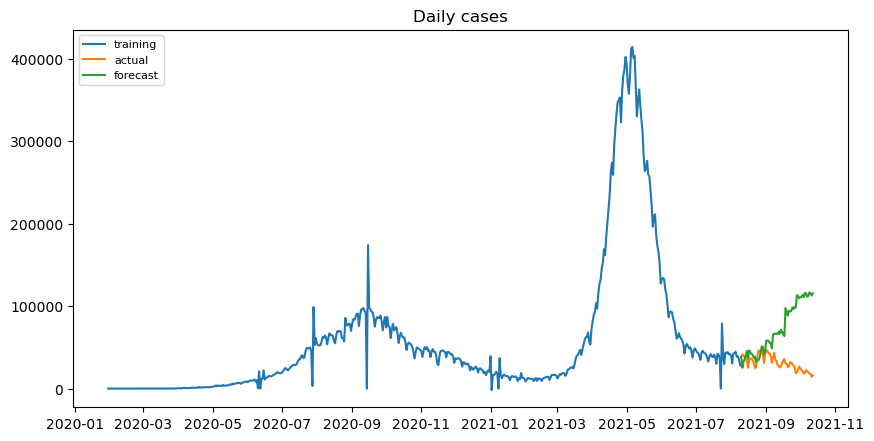

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [50]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')




In [51]:
mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']], title="Daily cases")



MAPE of Daily cases is 179.43442052252288%


In [52]:
mean_absolute_error(test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']])

42059.5738236295